# Лінійна регресія: перенавчання та регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх комірках, де написано коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Інші комірки з кодом (без коментарів) потрібно просто виконати. Крім того, у завданні потрібно відповідати на запитання; відповіді слід вписувати після виділеного слова "Відповідь:".

In [62]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Ми будемо працювати з датасетом "bikes_rent.csv", в якому щодня записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів цього дня. Останнє ми передбачатимемо; таким чином, ми вирішуватимемо завдання регресії.

### Знакомство с данными

# Завдання 1

Завантажте датасет за допомогою функції pandas.read_csv у змінну df. Виведіть перші 5 рядків, щоб переконатися у коректному зчитуванні даних:

In [63]:
#Додайте код
#Перевірте, що немає пропусків, також перевірте тип даних

#Завантажте датасет за допомогою функції pandas.read_csv у змінну df
df = pd.read_csv('bikes_rent.csv')
#Виведіть перші 5 рядків, щоб переконатися у коректному зчитуванні даних:
print(df.head(5))
# Перевірка на наявність пропусків
print('пропусків:')
print(df.isnull().sum())
# Виведення типів даних для кожного стовпця
print(df.dtypes)

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  
пропусків:
season            0
yr                0
mnth              0
holiday           0
weekday           0
workingday        0
weathersit        0
temp              0
atemp       

Для кожного дня прокату відомі такі ознаки:

* _season_: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: від 1 до 12
* _holiday_: 0 – немає свята, 1 – є свято
* _weekday_: від 0 до 6
* _workingday_: 0 - неробочий день, 1 - робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура у Цельсіях
* _atemp_: температура по відчуттям у Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях на годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, його ми передбачатимемо)

Отже, у нас є дійсні, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як із речовими. З номінальними ознаками теж можна працювати як із дійсними, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

Побудуйте графіки залежностей атрибутів від кількості подорожей. Тобто вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибуту від змінної **cnt**.

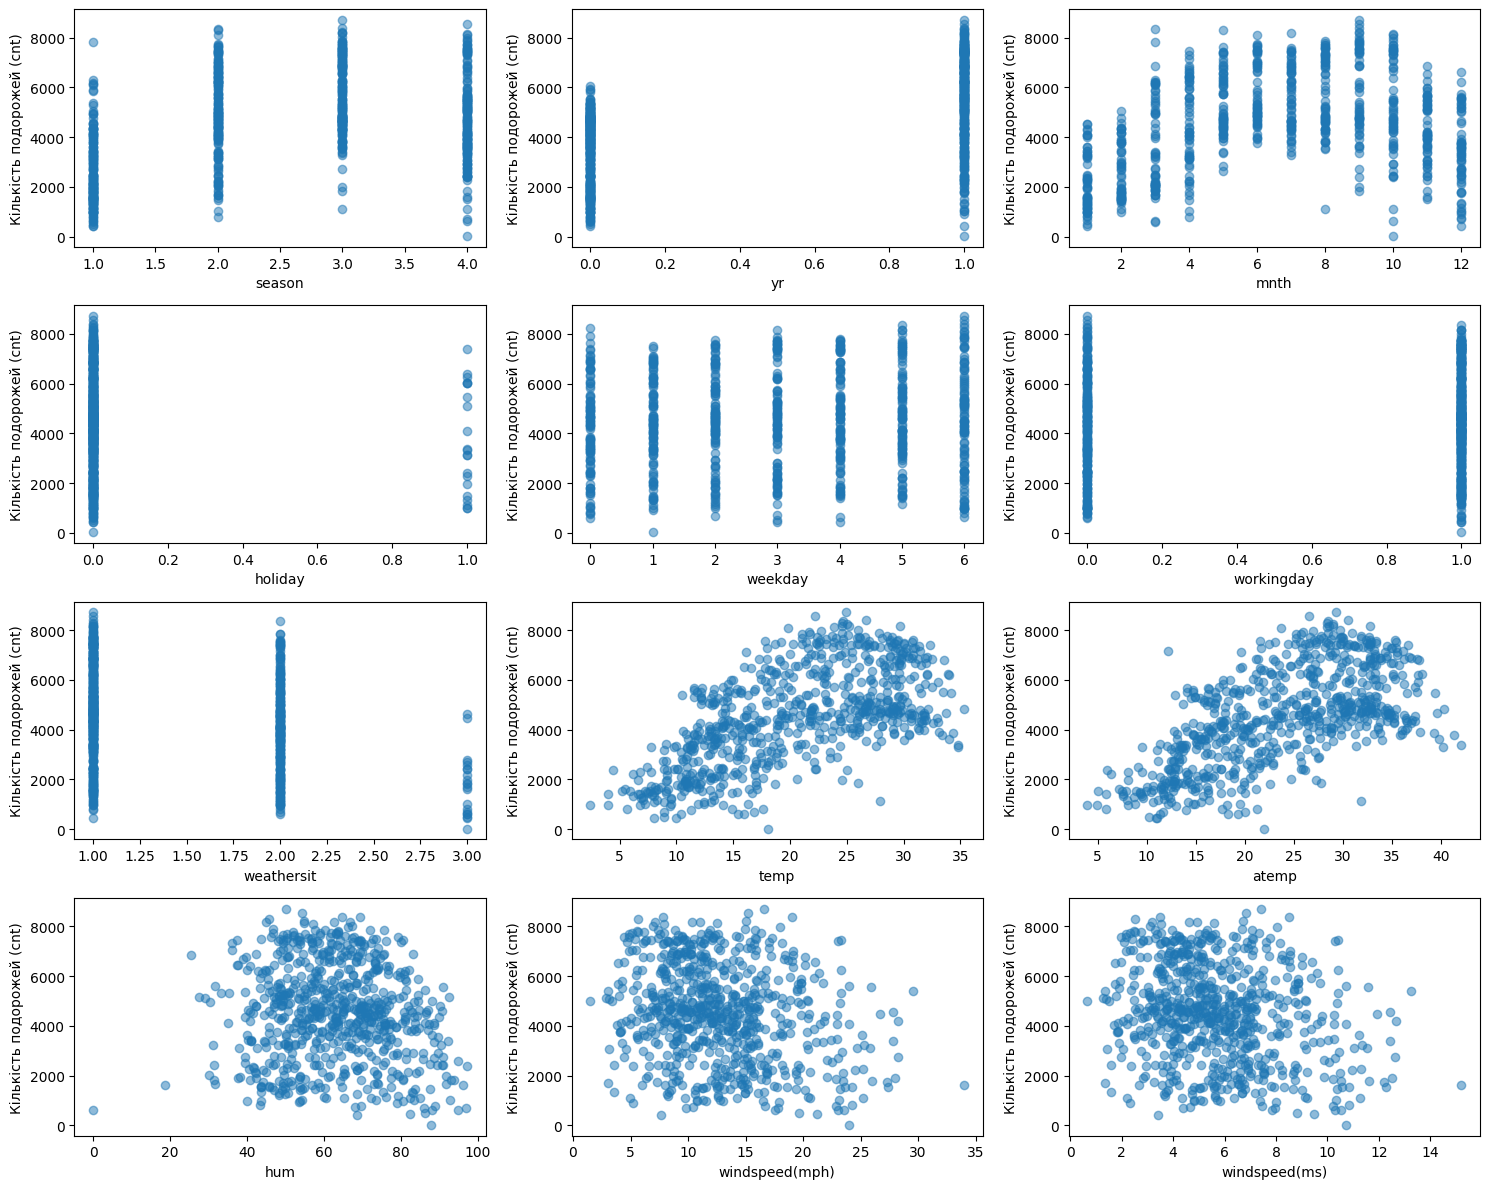

In [64]:
# Розмір графіків
plt.figure(figsize=(15, 12))

# Список атрибутів, для яких будуть будуватися графіки
attributes = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)']

# Побудова 12 графіків
for i, attribute in enumerate(attributes):
    plt.subplot(4, 3, i+1)  # Розмір сітки графіків 4x3
    plt.scatter(df[attribute], df['cnt'], alpha=0.5)
    plt.xlabel(attribute)
    plt.ylabel('Кількість подорожей (cnt)')

plt.tight_layout()
plt.show()

Питання:
1. Який характер залежності кількості прокатів від місяця? - **Кількість прокатів досягає свого максимума в місяці 5 - 10. Найменше прокатів у холодну погоду (тобто 12, 1, 2, 3 місяці). Квітень (4) є найбільш збалансованим**
1. Вкажіть одну чи дві ознаки, від яких кількість прокатів швидше за все залежить лінійно - **Ознаки, від яких кількість прокатів швидше за все залежить лінійно це *temp*, *atemp***


# Завдання 2

Давайте суворо оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Для її обчислення в pandas можна використовувати методи датафрейму: corr та corrwith.

Порахуйте кореляції всіх ознак, крім останньої, з останнім за допомогою методу `corrwith`.

In [65]:
# Визначення цільової змінної (кількість прокатів)
target_variable = df['cnt']

# Визначення ознак, з якими потрібно порахувати кореляції (усі ознаки крім останньої)
features = df.iloc[:, :-1]

# Розрахунок кореляцій за допомогою методу corrwith
correlations = features.corrwith(target_variable)

# Виведення кореляцій для кожної ознаки
print(correlations)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64


У вибірці є ознаки, що корелюють із цільовим, а отже, завдання можна вирішувати лінійними методами.

По графікам видно, деякі ознаки схожі один на одного. Тому давайте також порахуємо кореляції між дійсними ознаками.

# Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) та cnt
за допомогою методу corr:

In [66]:
# Виберемо відповідні стовпці для обчислення кореляцій
selected_columns = ['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']

# Обчислення кореляцій за допомогою методу corr
correlations = df[selected_columns].corr()

# Виведення кореляційної матриці
print(correlations)

                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


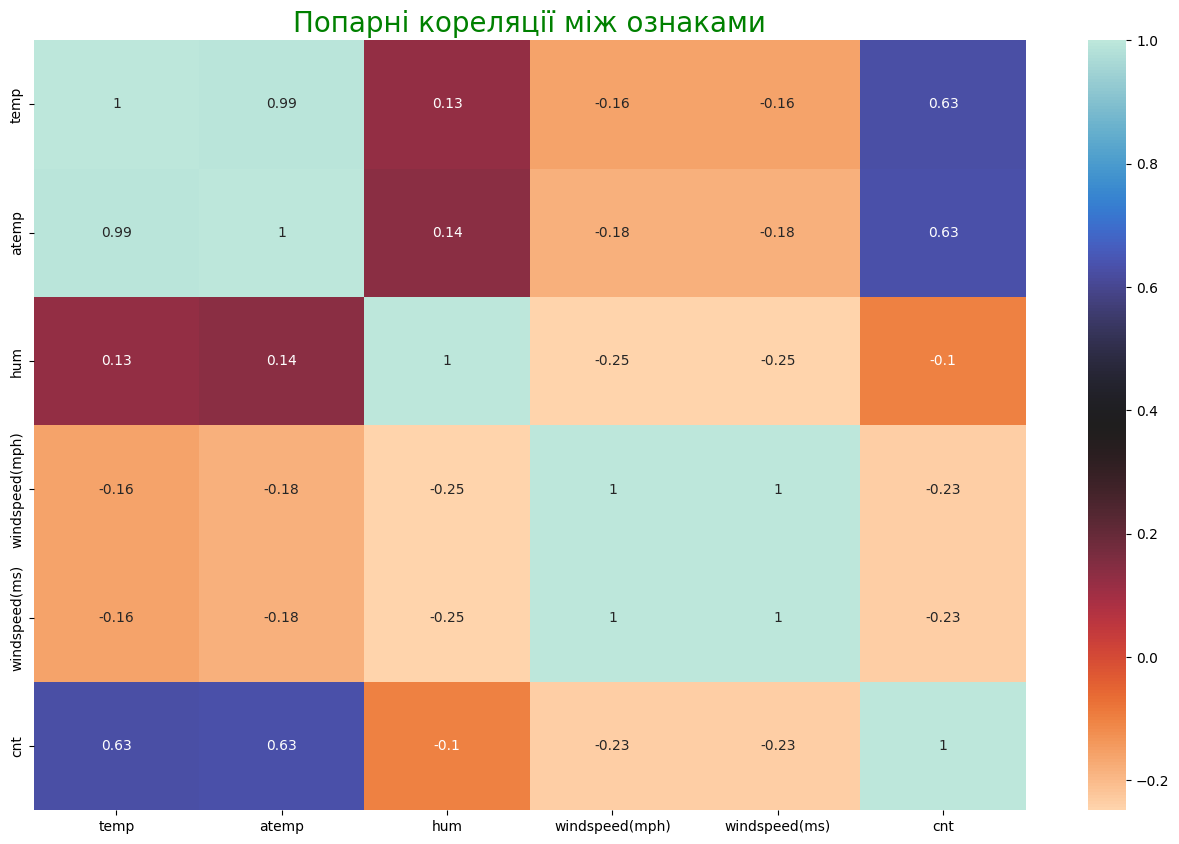

In [67]:
plt.rcParams["figure.figsize"] = (16, 10)
sns.heatmap(df.iloc[:, 7:].corr(), annot=True, cmap='icefire_r')
plt.title('Попарні кореляції між ознаками', fontsize=20, color='g')
plt.show()

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (бо це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно впливає на навчання лінійної моделі.

# Завдання 4

Виведіть середні ознаки

In [68]:
# Виведення середніх значень ознак
mean_values = df.mean()
print(mean_values)

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, в наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б відразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо його середнє і поділимо стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, потрібно перемішати вибірку, це буде потрібно для крос-валідації.

In [69]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [70]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [71]:
from sklearn.linear_model import LinearRegression

# Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються в змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.

In [72]:
reg = LinearRegression().fit(X, y)
[i for i in list(zip(df.columns, reg.coef_))]

[('season', 570.869840420185),
 ('yr', 1021.9648369366325),
 ('mnth', -141.3057498128626),
 ('holiday', -86.7602382288565),
 ('weekday', 137.22990306303458),
 ('workingday', 56.39005586999093),
 ('weathersit', -330.2330450008552),
 ('temp', 367.4652763382111),
 ('atemp', 585.5643746373447),
 ('hum', -145.6036472997277),
 ('windspeed(mph)', 12460406274500.414),
 ('windspeed(ms)', -12460406274698.863)]

Ми бачимо, що ваги при лінійно-залежних ознаках по модулю значно більші, ніж за інших ознак. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі у методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим меншим є визначник цієї матриці і тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколлінеарності_.

З парою (temp, atemp) трохи менш корелюючих змінних такого не сталося, проте на практиці завжди варто уважно стежити за коефіцієнтами за схожих ознак.

Для того, щоб вирішити проблему мультиколінеарності, потрібно скористатися регуляризатором. До функціонала, що оптимізується, додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а в другому --- Ridge.

# Завдання 6
Давайте спробуємо навчити лінійні моделі з L_1 і L_2-регуляризацією, а далі порівняємо їх ваги. Навчіть регресори Ridge і Lasso з параметрами за промовчанням і переконайтеся, що проблема з вагами вирішилася.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги

In [73]:
from sklearn.linear_model import Lasso, Ridge

In [74]:
lasso = Lasso().fit(X, y)
[i for i in list(zip(df.columns, lasso.coef_))]

[('season', 560.2416160308865),
 ('yr', 1019.4634940657198),
 ('mnth', -128.73062703678733),
 ('holiday', -86.15278133371098),
 ('weekday', 137.347893904963),
 ('workingday', 55.212370641356785),
 ('weathersit', -332.3698569623486),
 ('temp', 376.36323620969347),
 ('atemp', 576.5307935045563),
 ('hum', -144.12915500348578),
 ('windspeed(mph)', -197.13968940248455),
 ('windspeed(ms)', -2.805103823944435e-08)]

Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги

In [75]:
ridge = Ridge().fit(X, y)
[i for i in list(zip(df.columns, ridge.coef_))]

[('season', 563.0645722520163),
 ('yr', 1018.948378787527),
 ('mnth', -131.87332028247576),
 ('holiday', -86.74609799709245),
 ('weekday', 138.0051111787192),
 ('workingday', 55.90311037506427),
 ('weathersit', -332.3497884990726),
 ('temp', 386.45788919191114),
 ('atemp', 566.3470470600643),
 ('hum', -145.07132729867305),
 ('windspeed(mph)', -99.25944108182756),
 ('windspeed(ms)', -99.25944115430536)]

### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги за деяких ознак Давайте поспостерігаємо, як змінюються ваги при збільшенні коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги в список `coefs_ridge'` Конвертуйте отримані списки в `np.array`.

In [76]:
alphas = np.arange(1, 500, 50)

coefs_lasso = np.zeros((alphas.shape[0], X.shape[1]))
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))

for index, a in enumerate(alphas):
    lasso = Lasso(alpha=a)
    lasso.fit(X, y)
    coefs_lasso[index] = lasso.coef_

for index, a in enumerate(alphas):
    ridge = Ridge(alpha=a)
    ridge.fit(X, y)
    coefs_ridge[index] = ridge.coef_

Проаналізуйте динаміку ваги при збільшенні параметра регуляризації:

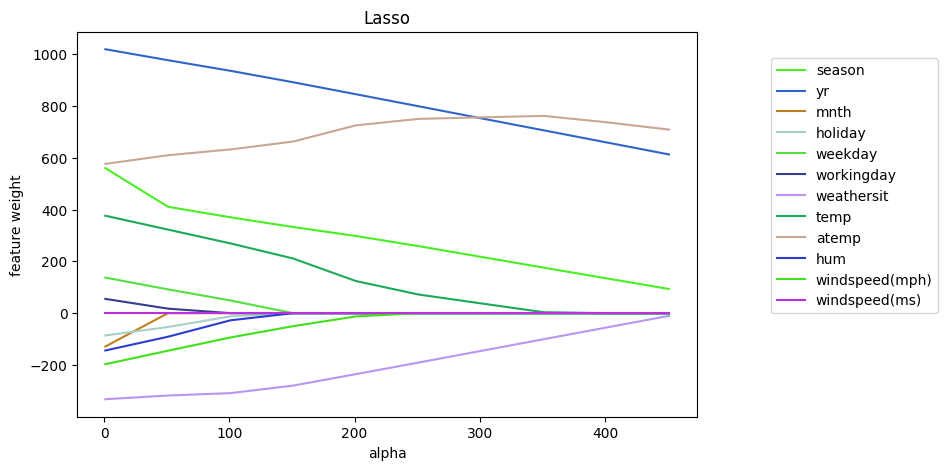

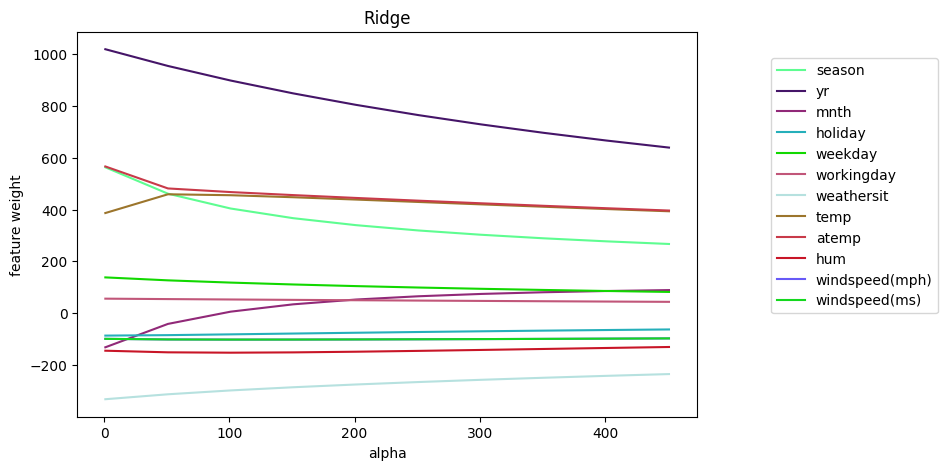

In [77]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` за будь-якого значення `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт за нього менше $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповіді:
1. `Lasso`
2. Це призведе до того, що всі ваги моделі `Lasso` будуть нульовими або дуже близькими до нуля. Ця ситуація відома як $"вибірковий відбір ознак"$ або $"L1-регуляризація"$. Причина цього полягає в особливості функції втрати `Lasso`. Функція втрати `Lasso` має член, який включає суму абсолютних значень ваг моделі:
$Lasso Loss = Ordinary Least Squares Loss + alpha * (|w1| + |w2| + ... + |wn|)$
Де $w1, w2, ..., wn$ - це ваги ознак моделі, а $alpha$ - параметр регуляризації. Якщо `alpha` дуже великий, то оптимальна стратегія для моделі полягатиме у тому, щоб мінімізувати вираз $|w1| + |w2| + ... + |wn|$ (сума абсолютних значень ваг) настільки, наскільки це можливо, одночасно мінімізуючи функцію втрати.
Це призведе до того, що багато з ваг моделі будуть рівні нулю (або дуже близькі до нуля), оскільки це дозволить мінімізувати вираз $|w1| + |w2| + ... + |wn|$ і при цьому збільшити загальний розмір втрат.
3. Так, `Lasso` може виключити одну з ознак `windspeed` за будь-якого значення `alpha > 0`. Властивість `Lasso`, що дозволяє виключити ознаки, називається $"вибірковим відбором ознак" (feature selection)$. Коли `alpha > 0`, `Lasso` штрафує великі коефіцієнти ваг, і якщо вага ознаки `windspeed` не є дуже важливою для побудови моделі, то `Lasso` може встановити цю вагу рівною нулю, виключивши таким чином цю ознаку з моделі.
Навпаки, Ridge регуляризація такого вибіркового відбору ознак не здійснює. Замість цього, Ridge штрафує великі значення ваг, але не призводить до повного виключення жодної ознаки, оскільки штрафує всі ваги пропорційно їхнім значенням. Це означає, що всі ознаки залишаються в моделі, хоча деякі з них можуть мати дуже малі коефіцієнти.
4. Для відбору неінформативних ознак, тобто ознак, які не мають суттєвого впливу на модель і можуть бути виключені з неї, зазвичай використовується `Lasso (L1-регуляризація)`. `Lasso` має властивість вибіркового відбору ознак, оскільки вона штрафує великі абсолютні значення коефіцієнтів ваг і може встановити деякі з них рівними нулю. Це означає, що `Lasso` призводить до автоматичного відбору найбільш інформативних ознак і виключає неінформативні.
`Ridge (L2-регуляризація)`, натомість, зазвичай не призводить до виключення ознак з моделі, а просто зменшує значення всіх коефіцієнтів ваг, включаючи інформативні та неінформативні. Таким чином, Ridge не є таким ефективним для відбору неінформативних ознак.
Отже, `Lasso` 🤠


### Завдання 8

Далі працюватимемо з `Lasso`.

Отже, бачимо, що з зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику функціонал методу найменших квадратів, що сам оптимізується, тобто `Mean Square Error`.

По-друге, треба зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не …анія на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбиття вибірки, на кожному пробувати різні значення alpha, а потім усереднити MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ часто, і щоразу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn дуже просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор міститиме змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (кількість блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків . Крім того, в змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а coef\_, традиційно, навчені ваги, відповідні цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, в якому він проходить через alphas; Для порівняння з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` залежно від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [78]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

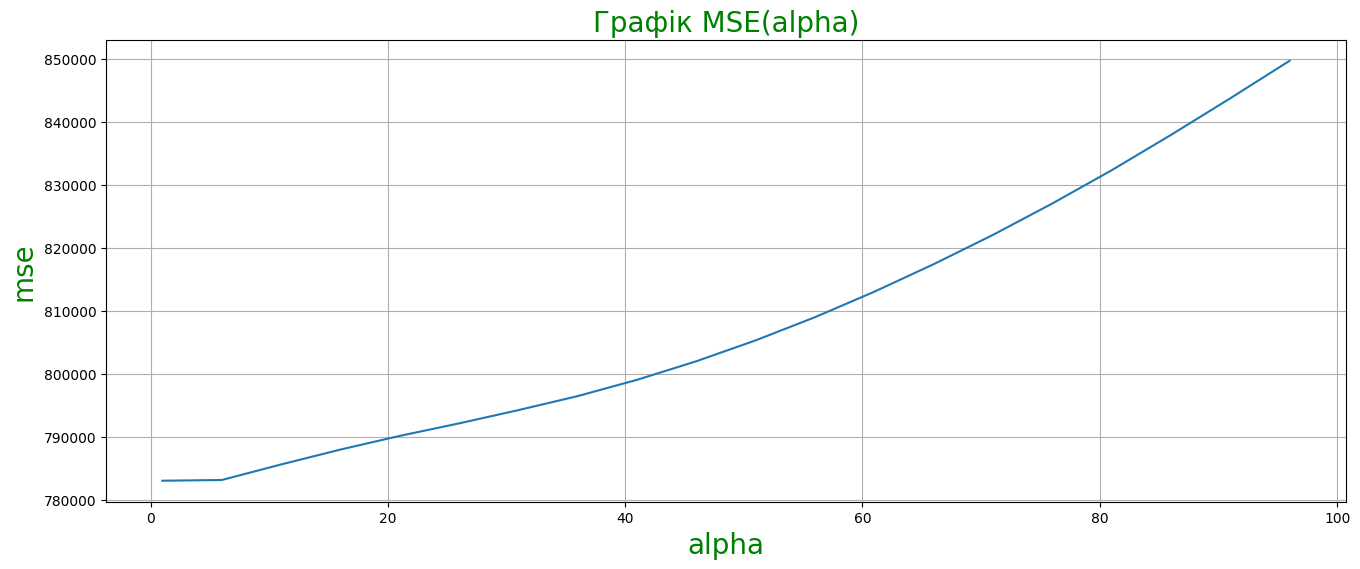

Alpha = 1


[('season', 560.2416160308865),
 ('yr', 1019.4634940657198),
 ('mnth', -128.73062703678733),
 ('holiday', -86.15278133371098),
 ('weekday', 137.347893904963),
 ('workingday', 55.212370641356785),
 ('weathersit', -332.3698569623486),
 ('temp', 376.36323620969347),
 ('atemp', 576.5307935045563),
 ('hum', -144.12915500348578),
 ('windspeed(mph)', -197.13968940248455),
 ('windspeed(ms)', -2.805103823944435e-08)]

In [79]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor =  LassoCV(alphas=alphas).fit(X, y)

mse = [i.mean() for i in regressor.mse_path_]

plt.rcParams["figure.figsize"] = (16, 6)
plt.plot(regressor.alphas_, mse)
plt.title('Графік MSE(alpha)', fontsize=20, color='g')
plt.xlabel("alpha", fontsize=20, color='g')
plt.ylabel("mse", fontsize=20, color='g')
plt.grid()
plt.show()

print(f'Alpha = {regressor.alpha_}')
[i for i in list(zip(df.columns, regressor.coef_))]

Отже, ми вибрали певний параметр регулювання. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбиття (тобто по стовпцях).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.

Alpha = 1, MSE = 691447.2507878079
Alpha = 11, MSE = 883471.1829425399
Alpha = 1, MSE = 710110.162411735
Alpha = 26, MSE = 860737.4059488717
Alpha = 21, MSE = 750676.356779


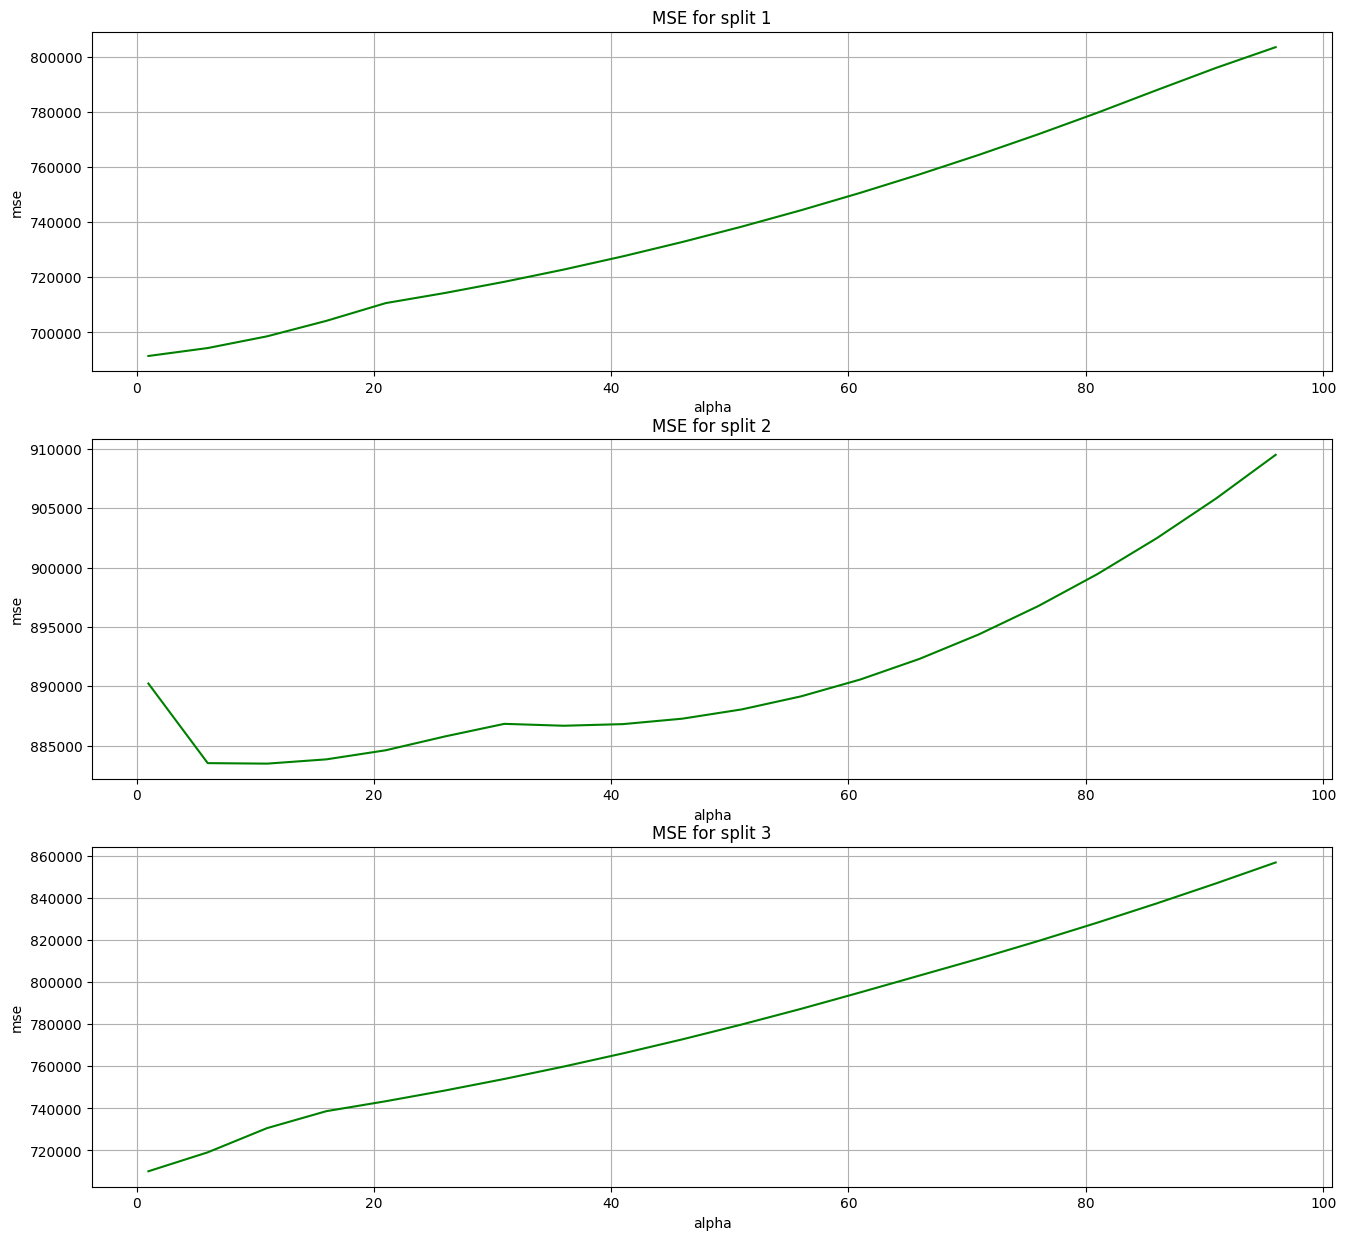

In [80]:
for i in range(3):
    plt.rcParams["figure.figsize"] = (16, 15)
    plt.subplot(3, 1, i+1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], c='g')
    plt.title(f'MSE for split {i+1}')
    plt.xlabel('alpha')
    plt.ylabel('mse')
    plt.grid()

for alpha, mse in enumerate(np.min(regressor.mse_path_, axis=0)):
    alpha_min = regressor.mse_path_[:, alpha].argmin(axis=0)
    print(f'Alpha = {regressor.alphas_[alpha_min]}, MSE = {mse}')

На кожному розбиття оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиття. Виходить, що ми налаштовуємось на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо щось "середнє", що даватиме прийнятне значення метрики на різних розбиття вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, проінтерпретуємо результат. Дайте відповідь на наступні запитання.

#### Питання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми малювали в блоці "Знайомство з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

Відповідь:
1. *Чи видно зростаючу лінійну залежність cnt від цих ознак за графіками?* - **Так видно зростаючу лінійну залежність `cnt` від цих ознак за графіками. 4 ознаки з найбільшими позитивними коефіцієнтами:**
   - season,
   - atemp,
   - yr,
   - windspeed(mph)
3. *Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?* - **Ні, не логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди. Оскільки за `atemp = 100` ніхто не захоче кататися на велосипеді, бо це занадто жарка погода 🥵 також при `windspeed(mph) = 200` всі захочуть сховатися в бункері від торнадо 🌪️, а не кататися на велосипеді 🚲. `yr = 3000` не гарантує нам найбільшого значення `cnt`, бо в 3000 році вже може не існувати такого поняття, як велосипед 👽**

In [81]:
# Отримання коефіцієнтів моделі
coefficients = reg.coef_

# Знайдення індексів 4 ознак з найбільшими позитивними коефіцієнтами
top_4_indices = np.argsort(coefficients)[-4:]

# Виведення назв цих ознак та їх коефіцієнтів
top_4_features = df.columns[top_4_indices]
top_4_coefficients = coefficients[top_4_indices]

print("4 ознаки з найбільшими позитивними коефіцієнтами:")
for feature, coefficient in zip(top_4_features, top_4_coefficients):
    print(f"{feature}: {coefficient}")

4 ознаки з найбільшими позитивними коефіцієнтами:
season: 570.869840420185
atemp: 585.5643746373447
yr: 1021.9648369366325
windspeed(mph): 12460406274500.414


#### Питання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться відповідні візуалізації. Чи видно лінійну залежність, яка зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

Відповідь:
1. *Чи видно лінійну залежність, яка зменшується?* - **Ці величини є негативними, що означає, що зі зростанням значень цих ознак. кількість прокатів `cnt` зменшується. 3 ознаки з найбільшими за модулем негативними коефіцієнтами:**
   - workingday: 56.39005586999093
   - holiday: -86.7602382288565
   - weekday: 137.22990306303458
2. Це може бути логічно в поясненні залежності. Наприклад:

- workingday: вища кількість прокатів може спостерігатися в вихідні дні або вільні дні, коли люди  мають більше часу на відпочинок і прокат велосипедів.
- holiday: коли люди також мають більше можливостей для прокату велосипедів.
- weekday: якщо вага для певного дня тижня є негативною, це може означати, що прокат велосипедів зазвичай менше в цей день.
  
**З цими ознаками і їхніми коефіцієнтами можна логічно пояснити зменшення кількості прокатів, коли значення цих ознак зростають.**

In [82]:
# Отримання коефіцієнтів моделі
coefficients = reg.coef_

# Знайдення індексів 3 ознак з найбільшими за модулем негативними коефіцієнтами
top_3_indices = np.argsort(np.abs(coefficients))[:3]

# Виведення назв цих ознак та їх коефіцієнтів
top_3_features = df.columns[top_3_indices]
top_3_coefficients = coefficients[top_3_indices]

print("3 ознаки з найбільшими за модулем негативними коефіцієнтами:")
for feature, coefficient in zip(top_3_features, top_3_coefficients):
    print(f"{feature}: {coefficient}")

3 ознаки з найбільшими за модулем негативними коефіцієнтами:
workingday: 56.39005586999093
holiday: -86.7602382288565
weekday: 137.22990306303458


#### Питання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (<1e-3). Як ви вважаєте, чому модель виключила їх із моделі (знов подивіться на графіки)? Чи правда, що вони не впливають на попит на велосипеди?

Відповідь:
1. Ознаки з коефіцієнтами близькими до нуля
   - holiday
   - weekday
   - workingday
     Модель виключила їх із моделі, тому що вони мають дуже низький вплив на попит на велосипеди
2. Так, це правда, що вони не впливають на попит на велосипеди. Проаналізувавши дані, можемо сказати, що ці ознаки мають дуже низький вплив на попит на велосипеди порівнюючи з іншими ознаками

### Висновок
напишіть висновок

В ході даної роботи було проведено аналіз та моделювання даних щодо прокату велосипедів 🚲 Я навчився виконувати наступні дії: ⚒️

1. **Завантаження та огляд даних:** Завантажив датасет, який містить інформацію про прокат велосипедів за різні дні, а також характеристики цих днів, такі як погода, місяць, робочий/вихідний день та інші.

2. **Візуалізація даних:** Побудував графіки для вивчення залежностей між різними ознаками та кількістю прокатів велосипедів `cnt`. На основі цього було виявлено патерни та тенденції в даних.

3. **Побудова та навчання моделі:** Побудував лінійню регресійну модель для прогнозу кількості прокатів велосипедів на основі характеристик дня. Модель була навчена на навчальних даних, і її результати були оцінені на валідаційних даних.

4. **Аналіз коефіцієнтів моделі:** Провів аналіз коефіцієнтів моделі, що дозволило визначити, які ознаки мають найбільший вплив на кількість прокатів велосипедів. Виявлені ознаки з позитивними та негативними коефіцієнтами.

5. **Відбір ознак:** Проаналізував коефіцієнти та визначив найважливіші ознаки для прогнозу та ознаки з низькими коефіцієнтами, які можуть бути виключені з моделі.

6. **Аналіз та моделювання даних:** Можна зробити наступні висновки:
   - Деякі ознаки, такі як день тижня, свята та робочі дні, мають суттєвий вплив на кількість прокатів велосипедів.
   - Ознаки, що вказують на погодні умови (наприклад, температура, вологість, швидкість вітру), також мають важливий вплив на прокат велосипедів.
   - Лінійна регресійна модель може бути корисною для прогнозу кількості прокатів велосипедів на основі наведених ознак.